In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

import gc
import pickle as pickle


from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf

In [3]:
gc.collect()

items           = pd.read_csv('items.csv',usecols=["item_id", "item_category_id"])
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train.csv.gz')
test            = pd.read_csv('test.csv.gz')

In [4]:
sales_train[['day','month', 'year']] = sales_train['date'].str.split('.', expand=True).astype(int)
sales_train = sales_train[sales_train['year'].isin([2013]) == False]
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id'))
sales_train.reset_index(inplace=True)

In [5]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
max_sales=1000
sums = sales_train.groupby('item_id')['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day":"item_total_sales"}).sort_values(by='item_total_sales')

ids_keep = sums[(sums['item_total_sales'] > 0) & (sums['item_total_sales'] < max_sales)]['item_id'].unique()

In [7]:
#train_item_ids = sales_train['item_id'].unique()
#train_item_ids = np.setdiff1d(train_item_ids, ids_reject)
train_item_ids = ids_keep
train_shop_ids = sales_train['shop_id'].unique()
test_item_ids = test['item_id'].unique()
test_shop_ids = test['shop_id'].unique()
train_blocks = sales_train['date_block_num'].unique()

all_item_ids = np.unique(np.append(test_item_ids,train_item_ids))
all_shop_ids = np.unique(np.append(train_shop_ids,test_shop_ids))


In [8]:
combinations = []

for dbn in range(np.min(train_blocks), np.max(train_blocks)+1):
    sales = sales_train[sales_train.date_block_num==dbn]
    #item_ids = np.intersect1d(sales.item_id.unique(), test_item_ids)
    item_ids = all_item_ids
    #dbn_combos = list(product(sales.shop_id.unique(), item_ids, [dbn]))
    dbn_combos = list(product(all_shop_ids, item_ids, [dbn]))
    for combo in dbn_combos:
        combinations.append(combo)
        
all_combos = pd.DataFrame(np.unique(np.vstack([combinations]), axis=0), columns=['shop_id','item_id','date_block_num'])

In [9]:
ys = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_item_cnt_block"})

training = all_combos.merge(ys, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)


training['shop_item_cnt_block'] = training['shop_item_cnt_block'].clip(0,20).astype('int8')

training = training.set_index('item_id').join(items.set_index('item_id'))
training.reset_index(inplace=True)

for col in ['item_id', 'shop_id', 'item_category_id']:
    training[col] = pd.to_numeric(training[col], downcast='unsigned')

In [10]:
dates = sales_train[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
training['month'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['month']), downcast='unsigned')
training['year'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['year']), downcast='unsigned')



In [11]:
training = training[(~training['date_block_num'].isin([22,23]))]

In [16]:
training.date_block_num.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33])

In [12]:
ys = sales_train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"item_cnt_block"})

training = training.merge(ys, on=['item_id', 'date_block_num'], how='left').fillna(0)

ys = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_cnt_block"})

training = training.merge(ys, on=['shop_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"category_cnt_block"})


training = training.merge(ys, on=['item_category_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['shop_id', 'item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_category_cnt_block"})

training = training.merge(ys, on=['shop_id', 'item_category_id', 'date_block_num'], how='left').fillna(0)


In [121]:
a = training.groupby(['shop_id','date_block_num'])['shop_cnt_block'].sum()\
                        .reset_index()
a = a[a['shop_cnt_block'] == 0]
closed_shop_ids = a["shop_id"].unique()
closed_shop_ids = np.setdiff1d(closed_shop_ids, [36])
print(closed_shop_ids)


#with pd.option_context('display.max_rows', 999):
    #print(a[a['item_cnt_block'] == 0])

training = training[~training['shop_id'].isin(closed_shop_ids)]

[ 9 13 17 20 27 29 30 33 34 39 40 43 48 51 54]


In [13]:
training['item_cnt_block_mean'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.mean)
training['item_cnt_block_min'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.min)
training['item_cnt_block_max'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.max)
training['item_cnt_block_std'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.std)
training['item_cnt_block_med'] = training.groupby(['item_id','year'])['item_cnt_block'].transform(np.median)

In [14]:
training['shop_cnt_block_mean'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.mean)
training['shop_cnt_block_min'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.min)
training['shop_cnt_block_max'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.max)
training['shop_cnt_block_std'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.std)
training['shop_cnt_block_med'] = training.groupby(['shop_id','year'])['shop_cnt_block'].transform(np.median)

In [15]:
training['category_cnt_block_mean'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.mean)
training['category_cnt_block_min'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.min)
training['category_cnt_block_max'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.max)
training['category_cnt_block_std'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.std)
training['category_cnt_block_med'] = training.groupby(['item_category_id','year'])['category_cnt_block'].transform(np.median)

In [16]:
training['shop_category_cnt_block_mean'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.mean)
training['shop_category_cnt_block_min'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.min)
training['shop_category_cnt_block_max'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.max)
training['shop_category_cnt_block_std'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.std)
training['shop_category_cnt_block_med'] = training.groupby(['shop_id', 'item_category_id','year'])['shop_category_cnt_block'].transform(np.median)

In [17]:
training['shop_item_cnt_block_mean'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.mean)
training['shop_item_cnt_block_min'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.min)
training['shop_item_cnt_block_max'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.max)
training['shop_item_cnt_block_std'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.std)
training['shop_item_cnt_block_med'] = training.groupby(['shop_id', 'item_id','year'])['shop_item_cnt_block'].transform(np.median)

In [28]:
training.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19086100 entries, 0 to 19086099
Data columns (total 36 columns):
item_id                         uint16
shop_id                         uint8
date_block_num                  int64
shop_item_cnt_block             int8
item_category_id                uint8
month                           uint8
year                            uint16
item_cnt_block                  float32
shop_cnt_block                  float32
category_cnt_block              float32
shop_category_cnt_block         float32
item_cnt_block_mean             float32
item_cnt_block_min              float32
item_cnt_block_max              float32
item_cnt_block_std              float32
item_cnt_block_med              float32
shop_cnt_block_mean             float32
shop_cnt_block_min              float32
shop_cnt_block_max              float32
shop_cnt_block_std              float32
shop_cnt_block_med              float32
category_cnt_block_mean         float32
category_cnt_block

In [283]:

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training.sample(10)

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,month,year,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,shop_item_cnt_block_mean,shop_item_cnt_block_min,shop_item_cnt_block_max,shop_item_cnt_block_std,shop_item_cnt_block_med,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med
5573325,22087,31,17,0,83,6,2014,33.0,7701.0,105.0,0.0,0.0,0,0,0.000000,0.0,40.2,14.0,83.0,20.966021,32.5,8615.6,7056.0,10017.0,915.964756,8520.0,150.2,46.0,309.0,92.624683,105.5,0.0,0.0,0.0,0.000000,0.0
4033932,15488,9,26,0,63,3,2015,0.0,0.0,2076.0,0.0,0.3,0,3,0.948683,0.0,5.8,0.0,14.0,5.311520,6.0,318.5,-1.0,3186.0,955.842604,0.0,1880.9,1316.0,2555.0,408.558703,1932.0,38.5,0.0,385.0,115.543446,0.0
843518,3443,3,32,4,30,9,2015,143.0,745.0,5303.0,171.0,1.6,0,4,1.264911,2.0,79.0,20.0,224.0,64.096865,59.0,715.8,535.0,977.0,108.940300,734.5,7487.0,4150.0,14751.0,2860.250222,6519.5,106.5,55.0,210.0,46.286811,89.5
3674254,14252,6,28,0,55,5,2015,5.0,1748.0,6353.0,192.0,0.3,0,2,0.674949,0.0,7.6,4.0,13.0,3.385443,6.0,1850.9,1484.0,2329.0,288.380469,1775.0,6895.7,4913.0,9291.0,1348.040733,6413.5,228.7,156.0,310.0,47.964073,226.5
2760521,10930,4,13,0,55,2,2014,11.0,1299.0,9442.0,124.0,0.2,0,1,0.421637,0.0,14.5,8.0,20.0,4.228843,14.5,1241.5,1090.0,1430.0,111.587142,1229.5,10110.4,8364.0,11533.0,1016.016085,9965.0,160.8,123.0,217.0,29.299962,168.0
3963479,15295,53,33,0,63,10,2015,1.0,1061.0,2149.0,27.0,0.2,0,1,0.421637,0.0,2.7,1.0,5.0,1.346610,3.0,1293.8,1061.0,1747.0,181.719007,1287.5,1880.9,1316.0,2555.0,408.558703,1932.0,24.4,15.0,34.0,6.202332,27.0
5361023,21021,55,15,0,61,4,2014,0.0,1271.0,94.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1676.2,1067.0,4229.0,915.542975,1313.0,354.3,94.0,1784.0,484.460616,188.5,0.0,0.0,0.0,0.000000,0.0
2746195,10889,47,29,0,55,6,2015,7.0,1740.0,6017.0,138.0,0.2,0,1,0.421637,0.0,9.4,3.0,17.0,4.413170,8.5,1947.8,1700.0,2410.0,207.579362,1902.5,6895.7,4913.0,9291.0,1348.040733,6413.5,157.4,116.0,205.0,26.768389,153.5
2356913,9354,21,27,0,70,4,2015,0.0,2053.0,1966.0,66.0,0.0,0,0,0.000000,0.0,4.7,0.0,47.0,14.113074,0.0,1823.8,1622.0,2053.0,124.217784,1841.5,1835.6,1024.0,2369.0,372.475927,1917.0,43.4,30.0,66.0,11.391891,40.5
1496339,5822,31,33,20,35,10,2015,259.0,6112.0,685.0,66.0,20.0,20,20,0.000000,20.0,412.8,211.0,843.0,211.592699,316.5,6765.9,5714.0,8815.0,893.551734,6416.0,994.6,568.0,2279.0,516.819406,724.5,87.1,58.0,159.0,34.186367,68.5


In [18]:
training.describe()

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,month,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med
count,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06,2.148720e+06
mean,1.101830e+04,3.166667e+01,2.850000e+01,2.388669e-01,4.627815e+01,1.257451e+01,1.659483e+03,3.773882e+03,8.193124e+01,5.500000e+00,1.257451e+01,3.116302e+00,4.066224e+01,1.149766e+01,8.791634e+00,1.659483e+03,1.307952e+03,2.294381e+03,2.985570e+02,1.594798e+03,3.773882e+03,2.520990e+03,5.851549e+03,9.875356e+02,3.444695e+03,8.193124e+01,5.224146e+01,1.262866e+02,2.226545e+01,7.812230e+01
std,6.246577e+03,1.753319e+01,2.872282e+00,1.068823e+00,1.676899e+01,8.034849e+01,1.400722e+03,3.751384e+03,1.708449e+02,2.872282e+00,6.182224e+01,2.927392e+01,1.920728e+02,5.007974e+01,5.266674e+01,1.324073e+03,1.081161e+03,1.904318e+03,3.460083e+02,1.270089e+03,3.522610e+03,2.405506e+03,5.108302e+03,8.299933e+02,3.245611e+03,1.602227e+02,1.067848e+02,2.707611e+02,5.498987e+01,1.506967e+02
min,3.000000e+01,2.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01,0.000000e+00,3.300000e+02,3.450961e+01,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.394250e+03,1.600000e+01,2.600000e+01,0.000000e+00,3.700000e+01,0.000000e+00,9.130000e+02,6.800000e+02,3.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,1.184627e+00,0.000000e+00,9.083000e+02,7.320000e+02,1.233000e+03,1.203324e+02,8.960000e+02,7.871000e+02,4.460000e+02,1.622000e+03,3.046295e+02,6.540000e+02,4.000000e+00,0.000000e+00,1.100000e+01,3.049556e+00,2.500000e+00
50%,1.119050e+04,3.450000e+01,2.850000e+01,0.000000e+00,4.300000e+01,2.000000e+00,1.251500e+03,2.203000e+03,3.100000e+01,5.500000e+00,4.200000e+00,0.000000e+00,1.100000e+01,3.138223e+00,2.000000e+00,1.298450e+03,9.885000e+02,1.706500e+03,1.830122e+02,1.303000e+03,1.880900e+03,1.316000e+03,4.824000e+03,9.188205e+02,1.917000e+03,3.180000e+01,1.600000e+01,5.700000e+01,1.162392e+01,3.000000e+01
75%,1.606725e+04,4.700000e+01,3.100000e+01,0.000000e+00,5.800000e+01,1.000000e+01,1.719000e+03,6.353000e+03,1.000000e+02,8.000000e+00,1.160000e+01,2.000000e+00,3.000000e+01,8.593942e+00,8.500000e+00,1.807200e+03,1.320000e+03,2.329000e+03,2.777342e+02,1.699500e+03,6.895700e+03,4.913000e+03,9.291000e+03,1.348041e+03,6.413500e+03,1.031000e+02,6.400000e+01,1.460000e+02,2.391182e+01,1.000000e+02
max,2.216700e+04,5.900000e+01,3.300000e+01,2.000000e+01,8.300000e+01,7.869000e+03,8.815000e+03,1.510900e+04,5.129000e+03,1.000000e+01,3.860600e+03,1.924000e+03,7.869000e+03,2.118527e+03,3.512000e+03,6.765900e+03,5.714000e+03,8.815000e+03,1.809498e+03,6.416000e+03,1.017430e+04,6.779000e+03,1.510900e+04,2.860258e+03,9.293500e+03,1.575700e+03,1.079000e+03,5.129000e+03,1.531763e+03,1.502500e+03


In [284]:
training.columns.values

array(['item_id', 'shop_id', 'date_block_num', 'shop_item_cnt_block',
       'item_category_id', 'month', 'year', 'item_cnt_block',
       'shop_cnt_block', 'category_cnt_block', 'shop_category_cnt_block',
       'shop_item_cnt_block_mean', 'shop_item_cnt_block_min',
       'shop_item_cnt_block_max', 'shop_item_cnt_block_std',
       'shop_item_cnt_block_med', 'item_cnt_block_mean',
       'item_cnt_block_min', 'item_cnt_block_max', 'item_cnt_block_std',
       'item_cnt_block_med', 'shop_cnt_block_mean', 'shop_cnt_block_min',
       'shop_cnt_block_max', 'shop_cnt_block_std', 'shop_cnt_block_med',
       'category_cnt_block_mean', 'category_cnt_block_min',
       'category_cnt_block_max', 'category_cnt_block_std',
       'category_cnt_block_med', 'shop_category_cnt_block_mean',
       'shop_category_cnt_block_min', 'shop_category_cnt_block_max',
       'shop_category_cnt_block_std', 'shop_category_cnt_block_med'],
      dtype=object)

In [23]:
features = [
    
    'item_cnt_block', 'shop_cnt_block',
       'category_cnt_block', 'shop_category_cnt_block',
       'item_cnt_block_mean', 'item_cnt_block_min', 'item_cnt_block_max',
       'item_cnt_block_std', 'item_cnt_block_med', 'shop_cnt_block_mean',
       'shop_cnt_block_min', 'shop_cnt_block_max', 'shop_cnt_block_std',
       'shop_cnt_block_med', 'category_cnt_block_mean',
       'category_cnt_block_min', 'category_cnt_block_max',
       'category_cnt_block_std', 'category_cnt_block_med',
       'shop_category_cnt_block_mean', 'shop_category_cnt_block_min',
       'shop_category_cnt_block_max', 'shop_category_cnt_block_std',
       'shop_category_cnt_block_med','shop_item_cnt_block_std'

]

In [18]:
training.fillna(0,inplace=True)

In [24]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 


training[features] = StandardScaler().fit_transform(training[features])



In [25]:
training[features] = training[features].apply(pd.to_numeric, downcast='float')

In [29]:
training[features].sample(10)

,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,...,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med,shop_item_cnt_block_std
15867266,-0.096362,-0.091232,1.082309,0.777916,-0.102974,-0.036045,-0.140845,-0.160395,-0.080618,-0.463598,...,1.098450,0.582494,-0.072385,0.972057,0.170803,-0.423705,0.395180,1.310049,0.298896,-0.271721
478512,-0.096362,-0.552007,-0.633964,-0.460923,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,-0.532253,...,-0.758455,-0.357484,0.111116,-0.741697,-0.483475,-0.423705,-0.498936,-0.476926,-0.479315,-0.271721
5556038,0.022274,-0.278955,-0.634318,-0.345233,0.273036,-0.006371,0.482778,0.511101,0.242253,-0.077692,...,-0.535656,-0.336608,0.017163,-0.459743,-0.254427,-0.259009,-0.242510,-0.106063,-0.315759,2.489753
12908199,-0.096362,-0.541262,-0.918357,-0.460923,-0.102974,-0.036045,-0.140845,-0.160395,-0.080618,-0.556797,...,-0.907230,-0.980260,-0.970005,-0.932920,-0.475385,-0.423705,-0.485440,-0.455692,-0.471401,-0.271721
17276859,-0.096362,-0.247984,-0.757212,-0.340413,-0.107477,-0.036045,-0.151239,-0.174707,-0.080618,-0.150381,...,-0.770067,-0.806107,-0.762011,-0.752229,-0.349990,-0.368806,-0.343731,-0.298540,-0.342139,-0.271721
5384699,-0.096362,1.609024,-0.851420,-0.388617,-0.096220,-0.036045,-0.130452,-0.144435,-0.080618,0.784226,...,-0.856187,-0.958683,-1.002444,-0.879389,-0.408643,-0.389393,-0.407837,-0.357769,-0.405451,-0.271721
15401563,0.002502,1.623562,2.312848,1.549178,-0.051189,-0.036045,-0.099271,-0.085692,-0.020827,1.817950,...,2.158985,2.058100,1.887002,2.127217,1.754923,1.840860,1.613201,1.157523,1.673296,0.418648
7695417,-0.096362,-0.350379,-0.854253,-0.407898,-0.107477,-0.036045,-0.151239,-0.174707,-0.080618,-0.400323,...,-0.850139,-0.907544,-0.900873,-0.855329,-0.443025,-0.409980,-0.461822,-0.434312,-0.437107,-0.271721
14269754,-0.096362,2.965437,-0.349040,0.898426,-0.109729,-0.036045,-0.161633,-0.187323,-0.080618,3.449932,...,-0.201819,-0.198463,-0.168866,-0.198371,1.457111,1.463433,1.265677,1.059206,1.425324,-0.271721
13997292,-0.076589,-0.604469,-0.696119,-0.403078,-0.105226,-0.036045,-0.151239,-0.170501,-0.080618,-0.586585,...,-0.731119,-0.723584,-0.659523,-0.762182,-0.396002,-0.341357,-0.390967,-0.371633,-0.397537,-0.271721


In [26]:
a = training[['shop_item_cnt_block'] + ['date_block_num','item_id', 'shop_id', 'year'] + features].sort_values(by=["date_block_num"]).groupby(["item_id", "shop_id", "year"])#['item_id_mean_encoding']#[features+['item_cnt_block']]

In [31]:
len(training['date_block_num'].unique())

20

In [32]:
sorted(training['date_block_num'].unique())[1:22][-1]

33

In [33]:
len(training)

19086100

In [27]:
#groups
lstm_data = []
lstm_y = []

for name, group in a:
    #print(group.values)
    steps = []
    ys = []
    #print("group.values",group.values)
    for step in group.values:
        #print(step)
        #print("step", len(step))
        #step is np.array 
        #step[4:] is np.array print(type(step[4:]))
        steps.append(step[5:])
        #print(step[9])
        #print(step[0])
        ys.append(step[0])
    #remove last
    #print(type(steps[0:8]))
    #jan to sept, y = oct
    lstm_data.append(np.array(steps[0:8]))
    #remove first
    #print(ys)
    #preditct for setptember
    lstm_y.append(ys[-1])
    
lstm_y = np.array([np.array([y]) for y in lstm_y])

In [28]:
small_data = np.array(lstm_data)
small_y = np.array(lstm_y)

In [24]:
small_data.shape

(1882656, 8, 25)

In [44]:
del lstm_data
del lstm_y
gc.collect()

851

In [29]:
print(len(lstm_y))

print(len([y for y in lstm_y if y == 0]))

zeros_indices = {}
for idx,y in enumerate(lstm_y):
    
    if y == 0:
        zeros_indices[idx] = True

1873908
1801396


In [30]:
lstm_data_no_zeros = []
for idx,sample in enumerate(lstm_data):
    if idx not in zeros_indices:
        lstm_data_no_zeros.append(sample)

In [32]:
lstm_zeros = []
for idx,y in enumerate(lstm_y):
    if idx in zeros_indices:
        lstm_zeros.append(idx)

In [41]:
#print(len(lstm_data_no_zeros))

for zero_idx in np.random.choice(lstm_zeros,35000,replace=False):
    lstm_data_no_zeros.append(lstm_data[zero_idx])
    lstm_y_no_zeros.append(lstm_y[zero_idx])

In [42]:
small_data = np.array(lstm_data_no_zeros)
small_y = np.array(lstm_y_no_zeros)

In [43]:
from sklearn.model_selection import train_test_split

train_data, val_data, y_train, y_val = train_test_split(small_data, small_y, test_size=0.1, random_state=42)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 64)             23040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 64)             256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 56,641
Trainable params: 56,385
Non-trainable params: 256
_________________________________________________________________
Train on 96760 samples, validate on 10752 samples
Epoch 1/100
96760/96760 [==============================] - 76s 782us/step - loss: 1.83

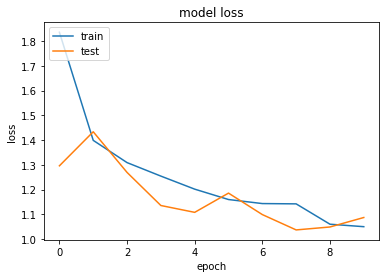

best rmse val: 1.0427625967152978


In [44]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization


#x_train_scaled = MinMaxScaler().fit_transform(x_train[features])


#x_reshaped = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 10, x_train_scaled.shape[1]))
    
#x_val_scaled_reshaped = np.reshape(x_val_scaled, (x_val_scaled.shape[0], 1, x_val_scaled.shape[1]))


callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]

dropout=0

my_model = Sequential()
#bi directional?
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 4, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
my_model.add(BatchNormalization())
#my_model.add(Dropout(dropout))
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 48, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features)), return_sequences=True))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 64, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
my_model.add(BatchNormalization())
#my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 4, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))
#my_model.add(Dropout(dropout))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()


#lstmd_dataa = np.array(np.array(lstm_data)).reshape(271148,8,51)
#print(lstmd_dataa.shape)
#print(lstmd_dataa)
#lstm_yy = np.array([np.array([y]) for y in lstm_y[0:100]])
#print(lstm_yy.shape)
#print(lstm_yy)

history = my_model.fit(train_data, y_train, batch_size=64, epochs=100,
                      validation_data=(val_data,y_val), callbacks=callbacks
                      )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

import math
print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [45]:
training_test = training[(training['shop_id'].isin(test['shop_id'].unique())) & (training['item_id'].isin(test['item_id'].unique()))]

In [46]:
len(test_lstm_data[0])

NameError: name 'test_lstm_data' is not defined

In [ ]:
test_lstm_data = []

for index, row in test.iterrows():
    if index % 10000 == 0:
        print(index)
    line = training_test[(training_test['shop_id'] == row['shop_id']) & (training_test['item_id'] == row['item_id'])].sort_values(by=['date_block_num'])[features].values
    test_lstm_data.append(line[1:22])

0


In [ ]:
training_test[(training_test['shop_id'] == 5) & (training_test['item_id'] == 5037)].sort_values(by=['date_block_num'])

In [176]:
preds = my_model.predict(np.array(test_lstm_data),batch_size=len(test_lstm_data))
preds.clip(0,20,out=preds)

array([[0.20451248],
       [0.01601815],
       [0.31358206],
       ...,
       [0.05747372],
       [0.        ],
       [0.26262653]], dtype=float32)

In [177]:

print(np.mean(preds))
print(np.max(preds))

0.20561361
10.890563


In [178]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds

submission.to_csv('submission.csv', index=False)

In [66]:
bestpreds = pd.read_csv('submissionbest.csv')['item_cnt_month']
print(np.mean(bestpreds))
print(np.max(bestpreds))

0.3542884257097005
16.49019305497366


In [ ]:
lr_preds = pd.read_csv('lr110.csv')['item_cnt_month']
lg_preds = pd.read_csv('lg110.csv')['item_cnt_month']
#cb_preds = pd.read_csv('cb102.csv')['item_cnt_month']


#preds = np.mean(np.array([lr_preds, lg_preds]),axis=0)

preds = (lg_preds * 0.50) + (lr_preds * 0.50)